# Modelling

## Modules and Packages

In [ ]:
from statistics import stdev
from traceback import print_tb
!pip install statsmodels maidenhead cartopy matplotlib numpy statistics seaborn pandas

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import maidenhead as mh
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns
import statistics
import statsmodels as sm
import scipy.stats as stats

## Importing Data

In [2]:
header_df = pd.read_pickle("../Data/Pre-Processed/header_updated.pickle")

# Clean up header data

cols_to_upper = ['CATEGORY-ASSISTED','CATEGORY-POWER']
for col in cols_to_upper:
    header_df[col] = header_df[col].str.upper()


In [3]:
categories_of_interest = ['CALLSIGN', 'CATEGORY-OPERATOR', 'CATEGORY-ASSISTED', 'CATEGORY-BAND', 'CATEGORY-POWER', 'CATEGORY-TRANSMITTER', 'CLAIMED-SCORE','GRID-LOCATOR', 'QSO_COUNT']
header_df = header_df[categories_of_interest]
header_df = header_df[header_df['QSO_COUNT'] != 0]

In [4]:
logs = pd.read_pickle("../Data/Pre-Processed/logs.pickle")

# Clean up log data

log_cols_to_upper = ['sent_call', 'rcvd_call']
for col in log_cols_to_upper:
    logs[col] = logs[col].str.upper()


### Note to self 

Data Quality - investigate issues and impact of these errors - Although so far we havent used rcvd callsign maybe errors are there

## QSO Count Distributions

In [103]:
data.describe()

count     7953.000000
mean       684.871495
std       1252.137772
min          1.000000
25%        114.000000
50%        290.000000
75%        719.000000
max      18446.000000
Name: QSO_COUNT, dtype: float64

### visual inspection (EDA again)

#### Histogram (RAW)

In [6]:
mod = statistics.mode(data=data)
print(mod)

100


In [16]:
# Settin Bin Width using Freedman - Diaconis rule

data = header_df['QSO_COUNT']
q25, q75 = np.percentile(data, (25, 75))
IQR = q75 - q25

n = len(data)

bin_w = ((2 * IQR) / n ** (1/3))

# Number of bins

range = np.max(data) - np.min(data)
bins = round(range/bin_w)
print(bins)

304


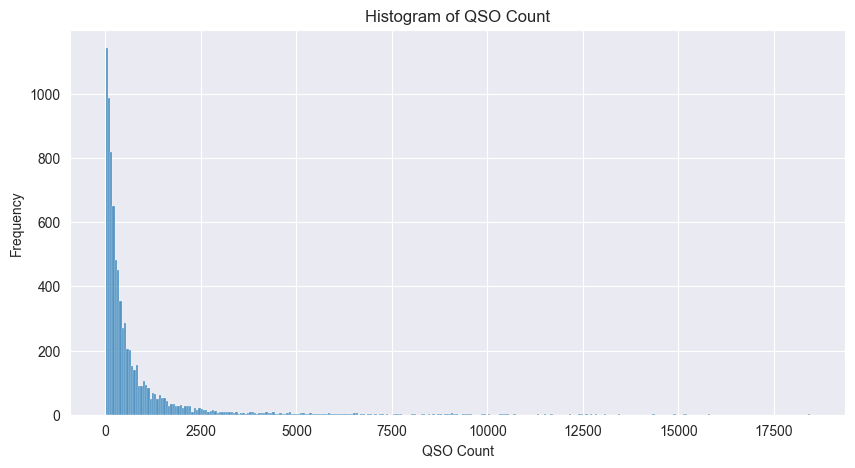

In [36]:
# Plotting Histogram

plt.figure(figsize=(10,5))
sns.histplot(data = data, bins = 304)
plt.title('Histogram of QSO Count')
plt.xlabel('QSO Count')
plt.ylabel('Frequency')
plt.show()

##### self notes

* heavily rightly skewed
* No local nodes (except initial dominant peak - global mode)
* Value Concentrated around 0 (Note - data is filtered to remove 0 from data since individual inspection suggests error in data entry) - so this entails bias.

#### Log transformation

In [8]:
# Log transformation

header_df['LOG_QSO_COUNT'] = np.log1p(header_df['QSO_COUNT'])

data_log = header_df['LOG_QSO_COUNT']

In [15]:
# Settin Bin Width using Freedman - Diaconis rule

q25, q75 = np.percentile(data_log, (25, 75))
IQR = q75 - q25

n = len(data_log)

bin_w = ((2 * IQR) / n ** (1/3))

# Number of bins

range = np.max(data_log) - np.min(data_log)
bins = round(range/bin_w)

print(bins)

50


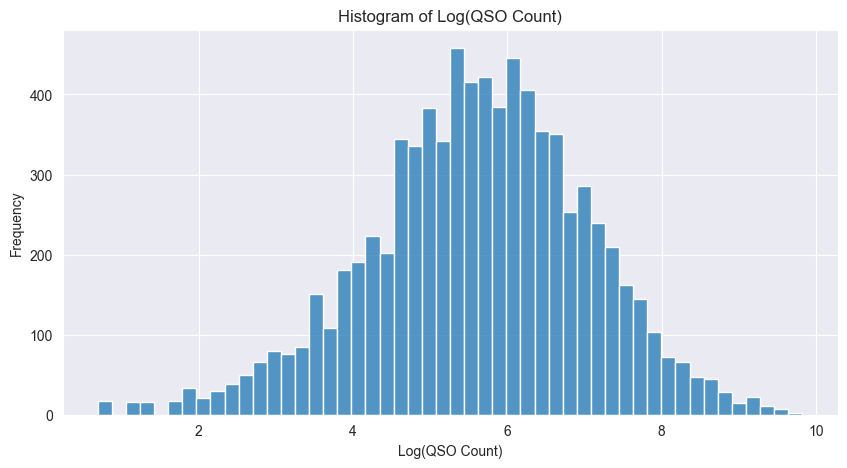

In [10]:
# Plotting Histogram

plt.figure(figsize=(10,5))
sns.histplot(data = data_log, bins = bins)
plt.title('Histogram of Log(QSO Count)')
plt.xlabel('Log(QSO Count)')
plt.ylabel('Frequency')
plt.show()

##### Self notes

* Gaussian distribution, bell curve
* unimodal
* Approximating a log normal distribution

##### QQ Plot

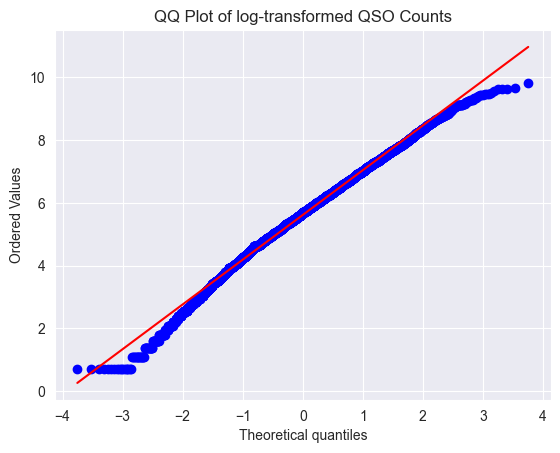

In [11]:
# Checking for Normality using QQ Plot

stats.probplot(data_log, dist="norm", plot=plt)
plt.title("QQ Plot of log-transformed QSO Counts")
plt.show()

* Strong evidence of normality
* lower tail suggesting a bit of skew
* upper tail also slightly deviates

#### ECDF

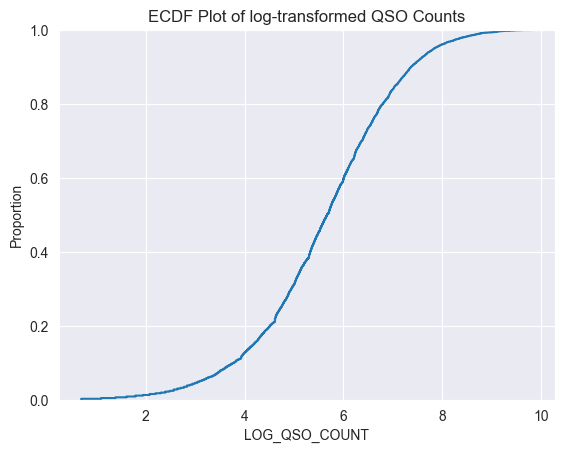

In [12]:
# Plotting an ECDF

sns.ecdfplot(data_log)
plt.title("ECDF Plot of log-transformed QSO Counts")
plt.show()

### Distribution and goodness of fit for log normal

Assumed distribution is Log Normal

#### Distribution fitting

In [14]:
# fitting a log normal to orginal count

shape, loc, scale = stats.lognorm.fit(data, floc=0)

# Generated data based on fitted distribution

x = np.linspace(data.min(), data.max(), 1000)
fitted_pdf = stats.lognorm.pdf(x, shape, loc=loc, scale=scale)

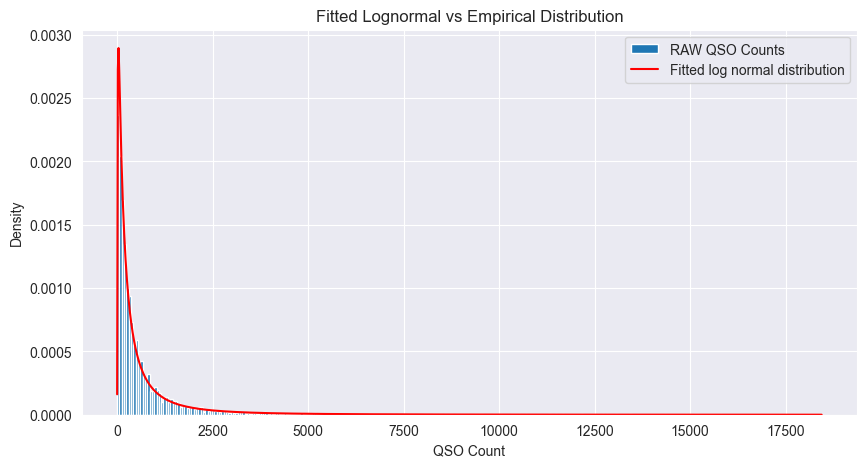

In [24]:
plt.figure(figsize=(10,5))

plt.hist(data, bins=304, density= True, label="RAW QSO Counts")
plt.plot(x, fitted_pdf, 'r-',label="Fitted log normal distribution")
plt.xlabel('QSO Count')
plt.ylabel('Density')
plt.title('Fitted Lognormal vs Empirical Distribution')
plt.legend()
plt.show()

#### Goodness of fit

Going to do a Chi - Squared Goodness of Fit test on the histogram bands. Current data to be used for observed frequency. Will calculate Expected Frequency based on Fitted distribution. I'm doing a quantile based binning because raw data is too skewed.

##### Chi squared test (on the bins)

In [89]:
# Quantile based binning and storing intervals

header_df['bin'] = pd.qcut(header_df['QSO_COUNT'], q = 10)

# Observed frequency

intervals = sorted(header_df['bin'].unique())
observed_frequency = np.zeros(len(intervals))

for i, interval in enumerate(intervals):
    for _ in header_df['bin']:
        if _ == interval:
            observed_frequency[i] += 1

intervals

[Interval(0.999, 43.0, closed='right'),
 Interval(43.0, 90.4, closed='right'),
 Interval(90.4, 140.0, closed='right'),
 Interval(140.0, 206.0, closed='right'),
 Interval(206.0, 290.0, closed='right'),
 Interval(290.0, 407.0, closed='right'),
 Interval(407.0, 587.0, closed='right'),
 Interval(587.0, 899.6, closed='right'),
 Interval(899.6, 1590.8, closed='right'),
 Interval(1590.8, 18446.0, closed='right')]

In [91]:
# Expected frequencies


prob = []

for interval in intervals:
    left = interval.left
    right = interval.right

    p1 = stats.lognorm.cdf(right, shape, loc=loc, scale=scale)
    p2 = stats.lognorm.cdf(left, shape, loc=loc, scale=scale)
    p = p1 - p2

    prob.append(p)

prob = np.array(prob)/sum(prob)

expected_frequency = np.array(prob)*n
expected_frequency



array([815.95199533, 975.04178663, 795.23276356, 800.67463116,
       745.0351208 , 730.45918443, 736.52155844, 740.55418879,
       739.97968222, 873.54908865])

In [93]:
statistic, pvalue = stats.chisquare(observed_frequency, expected_frequency, ddof= 6)

print(f"Chi-square test statistic: {statistic}, and p-value: {pvalue}")

Chi-square test statistic: 62.91020031479938, and p-value: 1.4036862064249198e-13


P value is too less, reject H0 - distribution does not fit the data well enough :(

##### ks test

In [99]:
ks_data = header_df['QSO_COUNT'].values

def cdf_fitted(x, shape = shape, loc = loc, scale = scale):
    '''
    cdf of lognormal distribution with pre set shape, loc, and scale
    '''
    return stats.lognorm.cdf(x, shape, loc=loc, scale=scale)

kstest, ks_pvalue = stats.kstest(ks_data, cdf_fitted)
print(f"KS test statistic: {ks_pvalue}, and p-value: {kstest}")


KS test statistic: 2.244356308605736e-09, and p-value: 0.03596897476518787


Again reject null hypothesis, p value < 0.05 :( - evidently lognormal is not a good fit

### Distribution and goodness of fit Negative binomial

In [ ]:
# fitting negative binomial

